# Optimal allocation of effort

In [6]:
%matplotlib inline
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import copy
import random

import fortuna

In [7]:
def dOdN(C,S):
    '''
    for the objective ln det C
    dOdC = C-1 = F
    dOdN = dOdC * dCdN, where dCdN = S (sensitivity tensor)
    '''
    F = np.linalg.pinv(C)
    dOdN = np.einsum('ij,ijkl->kl',F,S)
    return dOdN


def dOdN(C,S):
    '''
    for the objective ln det C
    dOdC = C-1 = F
    dOdN = dOdC * dCdN, where dCdN = S (sensitivity tensor)
    '''
    dOdC = np.ones(np.shape(C))
    dOdN = np.einsum('ij,ijkl->kl',dOdC,S)
    return dOdN


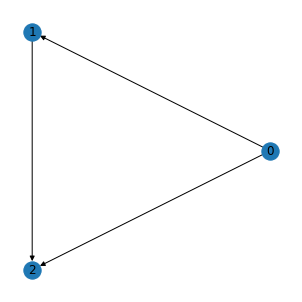

[0.0, 0.873552784275164, 0.9236302349376802]
[0.0, 0.9016860765393773, 1.3498554456229366]
[0.0, 0.4072171445121322, 0.9030596794271677]
[0.0, 0.35152930248384084, 0.7431507756964013]
[0.0, 0.32712198873866516, 0.5696549767708872]
[0.0, 0.27249236745387506, 0.4087280023733344]
[0.0, 0.2224791038973688, 0.4581565276832382]
[0.0, 0.2764038280318539, 0.4742458179873914]
[0.0, 0.1706336991805859, 0.5324419972961456]
[0.0, 0.24947292070609528, 0.4537789910091772]
[0.0, 0.30663221593650025, 0.43734949556301395]
[0.0, 0.2079785760363464, 0.5799908299634158]
[0.0, 0.22013211665447674, 0.688805928034339]
[0.0, 0.2846727570714176, 0.5987728201479059]
[0.0, 0.2669532698092709, 0.6036258178259262]
[0.0, 0.30964677728188406, 0.565861055443087]
[0.0, 0.26597756017361185, 0.5545082149920093]
[0.0, 0.22300070722368392, 0.6327460367003215]
[0.0, 0.22895277858870067, 0.6708027133088583]
[0.0, 0.22361601740503012, 0.5781178384018197]
[0.0, 0.227420613341085, 0.4898646209158226]
[0.0, 0.16077220960045313,

[0.0, -0.05645564950042736, 0.026541593109372652]
[0.9992346362663986, 0.9982297322901914, 1.00253563144341]
[0.0, -0.07997155874286754, 0.04135100443359718]
[0.9991719477459411, 0.9983328603657111, 1.0024951918883476]
[0.0, -0.018808969198921943, 0.08138812958458796]
[0.9991882841326459, 0.9983892884623258, 1.0024224274050282]
[0.0, -0.01770167555417146, 0.09739411763699479]
[0.9991240324835418, 0.9984871625378496, 1.0023888049786085]
[0.0, -0.011357046803031068, 0.1596174385202911]
[0.99910395802978, 0.9985623234041604, 1.0023337185660597]
[0.0, -0.011859635901445564, 0.18225623479595487]
[0.9992874234648725, 0.9984371630764612, 1.0022754134586664]
[0.0, -0.01759425952086957, 0.17462629110095396]
[0.9992184654742053, 0.9985371258261255, 1.0022444086996691]
[0.0, -0.04209325556158827, 0.16155341664290734]
[0.9992483958223951, 0.9985670338747773, 1.0021845703028276]
[0.0, -0.03311647482504387, 0.133205622882127]
[0.9993465776977453, 0.9985550799073127, 1.0020983423949417]
[0.0, -0.0327

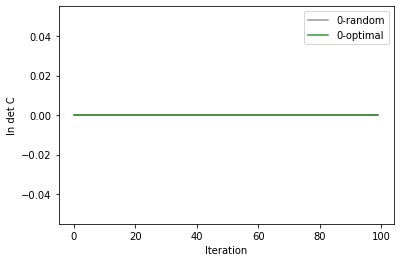

In [16]:
n_ligands = 3
repeats = 1
Nmax = 100 # maximum number of iterations to simulate
# probability = 0.95 # probability threshold separating best and worst ligands for stopping the simulation

g = fortuna.graph.create_graph(n_ligands=n_ligands)
fortuna.graph.assign_uniform_weights(g)
fortuna.graph.realize_experiment(g)

#initialize everything
N0_ij = 10 * np.ones([n_ligands, n_ligands],dtype=int)

# calculate the fisher information matrix
F = fortuna.optimize.fisher_information_matrix(g, N0_ij)

# Compute the covariance matrix
labels = {}
for i in range(n_ligands):
    labels[i] = str(i)

plt.figure(figsize=(4,4))
nx.draw_circular(g,labels=labels)
plt.show()

score = np.zeros([Nmax])

color = {'random':'gray','optimal':'green'}
    
#calculate the 'real' free energies
f_i, C = fortuna.graph.mle(g,estimate=False) # compute free energy differences    
edges = [edge for edge in g.edges()]
indecies = [i for i in range(len(edges))]
for expt in ['random','optimal']:
    for repeat in range(repeats):
        fortuna.graph.reset_experiment(g,N0_ij)
        for step in range(Nmax):
            N_ij = fortuna.graph.form_edge_matrix(g, 'n_samples', action='symmetrize')
            s_ij = fortuna.graph.form_edge_matrix(g, 'statistical_fluctuation_est', action='symmetrize')

            C_ij = fortuna.optimize.estimate_correlation_matrix(s_ij, N_ij)
            f_i_est, _ = fortuna.graph.mle(g,estimate=True) # compute free energy differences    

            # this needs to be changed depending on wh
            print([a - b for a,b in zip(f_i,f_i_est)])
        
            if expt == 'random':
                for edge in g.edges():
                    g.edges[edge]['weight'] = 1 / len(edges)
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]    
            elif expt == 'optimal':
                S = fortuna.optimize.sensitivity_tensor(g,N_ij)
                dO_dN = dOdN(C_ij,S)
                w_ij = dO_dN / dO_dN.sum()    
                for edge in g.edges():
                    i,j = edge
                    g.edges[edge]['weight'] = w_ij[i,j]*2
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]
            if expt == 'optimal':
                print([x*len(weights) for x in weights])
            for index in np.random.choice(indecies,size=10,p=weights):
                chosen_edge = edges[index]
                g.edges[chosen_edge]['n_samples'] += 1
                samples = g.edges[chosen_edge]['samples'][0:g.edges[chosen_edge]['n_samples']]
                g.edges[chosen_edge]['f_ij_est'] = np.mean(samples)  
                g.edges[chosen_edge]['df_ij_est'] = np.std(samples) / np.sqrt(len(samples))
                g.edges[chosen_edge]['statistical_fluctuation_est'] = np.std(samples)
            
#             N_ij = fortuna.graph.form_edge_matrix(g, 'n_samples', action='symmetrize')
        plt.plot(score,'-',alpha=0.8,label=str(repeat)+'-'+str(expt),color=color[expt])
            
plt.xlabel('Iteration')
plt.ylabel('ln det C')
# plt.plot(score,'-',alpha=0.8,label=str(i))
plt.legend()
plt.show()

In [4]:
for edge in g.edges(data=True):
    print(edge[0:2])
    print(edge[2]['statistical_fluctuation'])
    print(edge[2]['statistical_fluctuation_est'])

(0, 3)
3.5089533438511604
3.3803002082277795
(0, 6)
2.8100826219547637
2.7922120409141686
(0, 9)
5.071547023072253
4.979371850884827
(1, 5)
4.171596155660986
4.222293476331668
(1, 8)
3.1928106391118938
3.190320890467652
(2, 4)
3.3574203907459466
3.4105098796624764
(2, 7)
3.3583482588512847
3.3059216082800305
(2, 9)
4.936546170498873
5.073821866110957
(3, 5)
4.767369336824513
4.750502459564974
(3, 8)
6.423145910480314
6.612764928907316
(4, 6)
3.502539689233605
3.4769085383033986
(4, 8)
5.2954767379232015
5.164657061377594
(5, 7)
9.026574142680886
9.099010604884494
(6, 7)
1.487753706109519
1.5376417901081976


In [5]:
# n_ligands = 20
# Nmax = 1 # maximum number of iterations to simulate
# K = 3 # number of lowest free energy ligands to identify
# probability = 0.95 # probability threshold separating best and worst ligands for stopping the simulation
# P_i = np.zeros([Nmax]) # probability that criteria is satisfied as a function of sample number

# g = fortuna.graph.create_graph(n_ligands=n_ligands)
# fortuna.graph.assign_uniform_weights(g)
# fortuna.graph.realize_experiment(g)

# #initialize everything
# N0_ij = 5 * np.ones([n_ligands, n_ligands],dtype=int)

# # calculate the fisher information matrix
# F = fortuna.optimize.true_fisher_information_matrix(g, N0_ij)

# # Compute the covariance matrix
# C = fortuna.optimize.covariance_matrix(F)

# plt.figure(figsize=(4,4))
# nx.draw_circular(g)
# plt.show()
    
# # get an initial guess of the free energy, variance and stat. flux. 
# for edge in g.edges(data=True):
#     i, j, edge_data = edge
#     n_steps = N0_ij[i,j]
#     edge_data['n_samples'] = n_steps
#     samples = edge_data['samples'][0:edge_data['n_samples']]
#     edge_data['f_ij_est'] = np.mean(samples)  
#     edge_data['df_ij_est'] = np.std(samples) / np.sqrt(len(samples))
#     edge_data['statistical_fluctuation_est'] = np.std(samples)
    
# f_i_est, C = fortuna.graph.mle(g,estimate=True) # compute free energy differences    

# #calculate the 'real' free energies
# f_i, C = fortuna.graph.mle(g,estimate=False) # compute free energy differences    
# indices = np.argsort(f_i)
# best_ligands = indices[0:K]
# worst_ligands = indices[K:]

# #   # Estimate how many iterations are needed to reach the specified probability threshold 
# #   N0_ij = form_edge_matrix(g, 'n_samples', action='symmetrize')
# #   s_ij = form_edge_matrix(g, 'statistical_fluctuation', action='symmetrize')
# #   w_ij = form_edge_matrix(g, 'weight', action='symmetrize')


# for step in range(Nmax):
#     N_ij = fortuna.graph.form_edge_matrix(g, 'n_samples', action='symmetrize')
#     s_ij = fortuna.graph.form_edge_matrix(g, 'statistical_fluctuation_est', action='symmetrize')

#     C_ij = fortuna.optimize.estimate_correlation_matrix(s_ij, N_ij)
#     f_i_est, _ = fortuna.graph.mle(g,estimate=True) # compute free energy differences    

#     Ptotal = 1.0
#     for i in best_ligands:
#         for j in worst_ligands:
#             delta_f = f_i_est[j] - f_i_est[i] # should be positive if worst_ligands > best_ligands
#             ddelta_f = np.sqrt(C_ij[i,i] + C_ij[j,j] - 2*C_ij[i,j]) # statistical error in delta_f
#             z = delta_f / ddelta_f # z-score (number of standard deviations separated)
#             P = 1.0 - 0.5*scipy.special.erfc(z/np.sqrt(2)) # probability that best ligand is better than worst ligand
#             Ptotal *= P
#             print((i,j,P))
#     P_i[step] = Ptotal  
    
# plt.plot(P_i,'-',alpha=0.8,label=str(i))
# plt.show()
